In [1]:
import sys
sys.path.append('../auton_survival/')
from datasets import load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## 1. Generative Process for the Synthetic Data

1. Features $x_1$, $x_2$ and the base survival phenotypes $Z$ are sampled from $\texttt{scikit-learn's make_blobs(...)}$ function which generates isotropic Gaussian blobs:
$$[x_1, x_2], Z \sim \texttt{sklearn.datasets.make_blobs(K = 3)}$$
2. Features $x_3$ and $x_4$ are sampled uniformly, whereas the underlying treatment effect phenotypes $\phi$ are defined according to an $L_1$-ball:
$$ [x_1, x_2] \sim \texttt{Uniform}(-2, 2) $$
$$ \phi \triangleq \mathbb{1}\{|x_3| + |x_3| > 2\} $$
3. We then sample treat assignments from a Bernoulli distribution:
$$ A \sim  \texttt{Bernoulli}(\frac{1}{2}) $$
4. Next, the time-to-event $T$ conditioned on the confounders $x$, latent $Z$ and latent effect group $\phi$ are generated from a Gompertz distribution:
$$ T^{*}| (Z=k, {\phi}=m, A={a}) \sim \nonumber \texttt{Gompertz}\big({\beta}_{k}^{\top}{x} +({-a}^m)\big) $$
5. Finally, the observed time $T$ is obtained after censoring some of the events and censoring time is chosen uniformly at random upto $T^*$:
$$\delta \sim \texttt{Bernoulli}(\frac{3}{4}), \quad C \sim \texttt{Uniform}(0, {T}^{*})$$
$$ T =  \begin{cases} T^*, & \text{if } \delta = 1 \\ C, & \text{if } \delta = 0 \end{cases} $$

## 2. Visualizing the Synthetic Dataset

In [2]:
# Load the synthetic dataset
outcomes, features, interventions = load_dataset(dataset='SYNTHETIC')

In [3]:
# Let's take a look at take the dataset
features.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.148745,1.892484,0.195254,0.860757,0.696523,0.483697,0.339551,0.374794
1,1.139439,-0.943330,0.411054,0.179533,0.428686,0.683057,0.600948,0.070483
2,-0.961237,0.782706,-0.305381,0.583576,0.157478,0.070556,0.034590,0.776005
3,0.466508,0.694348,-0.249651,1.567092,0.850959,0.416178,0.968841,0.863598
4,-0.249002,-0.552091,1.854651,-0.466234,0.860385,0.367184,0.954347,0.748930


(-2.25, 2.25)

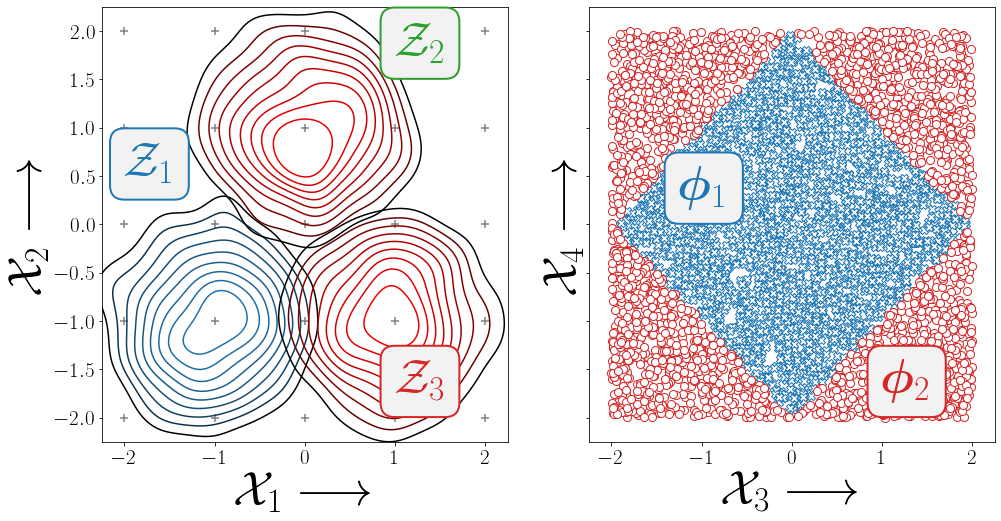

In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"
fs = 48 # Font size
s = 65 # Size of the marker
lim = 2.25

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16,8), sharey=True)
color_maps = {
    0: LinearSegmentedColormap.from_list("z1", colors=['black', 'C0']),
    1: LinearSegmentedColormap.from_list("z1", colors=['black', 'r']),
    2: LinearSegmentedColormap.from_list("z1", colors=['black', 'r'])
}
for cmap in color_maps: color_maps[cmap].set_gamma(0.4)
    
# Data
X1, X2, X3, X4 = features.X1.to_numpy(), features.X2.to_numpy(), features.X3.to_numpy(), features.X4.to_numpy()

# First sub-plot X1 vs X2
for z in set(outcomes.Z):
    mask = (outcomes.Z == z)
    sns.kdeplot(ax=ax1, x=X1[mask], y=X2[mask], 
                fill=False,  levels=10, thresh=0.3, 
                cmap=color_maps[z])

ax1.tick_params(axis="both", labelsize=21)
ax1.set_xlabel( r'$\mathcal{X}_1 \longrightarrow$', fontsize=fs)
ax1.set_ylabel( r'$\mathcal{X}_2 \longrightarrow$', fontsize=fs)
ax1.text(-2,0.5, s=r'$\mathcal{Z}_1$', color='C0', fontsize=fs, 
         bbox=dict(lw=2, boxstyle="round", ec='C0', fc=(.95, .95, .95)))
ax1.text(1,1.75, s=r'$\mathcal{Z}_2$', color='C2', fontsize=fs, 
         bbox=dict(lw=2, boxstyle="round", ec='C2', fc=(.95, .95, .95)))
ax1.text(1,-1.75, s=r'$\mathcal{Z}_3$', color='C3', fontsize=fs, 
         bbox=dict(lw=2, boxstyle="round", ec='C3', fc=(.95, .95, .95)))
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

# Second sub-plot X1 vs X2
# n  = 21
# X = np.meshgrid(np.linspace(-2, 2, n), np.linspace(-2, 2, n))
# X1 = X[0].ravel()
# X2 = X[1].ravel()
R = (np.abs(X3) + np.abs(X4))<=2
ax2.scatter(X3[R], X4[R], s=s, c='white', marker='X',ec='C0')
ax2.scatter(X3[~R], X4[~R], s=s, c='white', marker='o', ec='C3')

grid = np.meshgrid([2, 1, 0, -1, -2], [2, 1, 0, -1, -2])
ax1.scatter(grid[0].ravel(), grid[1].ravel(), color='grey', marker='+', zorder=-500, s=50)

ax2.set_xlabel(r'$\mathcal{X}_3 \longrightarrow$', fontsize=fs)
ax2.set_ylabel(r'$\mathcal{X}_4 \longrightarrow$', fontsize=fs)
ax2.text(-1.25,.25, s=r'$\bm{\phi}_1$', color='C0', fontsize=fs, 
         bbox=dict( lw=2, boxstyle="round", ec='C0', fc=(.95, .95, .95)))
ax2.text(1,-1.75, s=r'$\bm{\phi}_2$', color='C3', fontsize=fs, 
         bbox=dict( lw=2, boxstyle="round", ec='C3', fc=(.95, .95, .95)))
ax2.tick_params(axis="both", labelsize=21)
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)